In [91]:
import time
!pip install feedparser
import feedparser
import requests
import pandas as pd
import networkx as nx
import math
import re
import json
from collections import defaultdict, Counter
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import community as community_louvain

In [71]:
QUERY = 'all:"artificial intelligence"'
NUM_PAPERS = 250
SLEEP_BETWEEN_REQUESTS = 3.0
TOP_K_KEYWORDS = 10
MIN_KEYWORD_DOC_FREQ = 1

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\n',' ').strip()
    return text

def preprocess_for_keywords(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s\-]', ' ', text)
    tokens = [t for t in text.split() if t not in STOPWORDS and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

def fetch_arxiv(query=QUERY, num_papers=NUM_PAPERS, sleep_sec=SLEEP_BETWEEN_REQUESTS):
    base = 'http://export.arxiv.org/api/query?'
    results = []
    start = 0
    batch = 100
    pbar = tqdm(total=num_papers, desc="Fetching arXiv")
    while len(results) < num_papers:
        to_fetch = min(batch, num_papers - len(results))
        q = f'search_query={requests.utils.quote(query)}&start={start}&max_results={to_fetch}'
        url = base + q
        resp = requests.get(url, headers={'User-Agent': 'arXiv-ML-Keyword-Graph/0.1'})
        if resp.status_code != 200:
            raise RuntimeError(f"arXiv API returned {resp.status_code}")
        feed = feedparser.parse(resp.content)
        entries = feed.entries
        if not entries:
            break
        for e in entries:
            entry = {}
            entry['id'] = e.get('id')
            entry['title'] = clean_text(e.get('title',''))

            authors = []
            if 'authors' in e:
                authors = [a.name for a in e.authors]
            entry['authors'] = authors
            entry['summary'] = clean_text(e.get('summary',''))
            results.append(entry)
            pbar.update(1)
            if len(results) >= num_papers:
                break
        start += to_fetch
        time.sleep(sleep_sec)
    pbar.close()
    return results[:num_papers]

In [72]:
def extract_keywords(docs, top_k=TOP_K_KEYWORDS, ngram_range=(1,2)):
    corpus = []
    ids = []
    for d in docs:
        txt = (d['title'] + ' ' + d['summary']).strip()
        corpus.append(preprocess_for_keywords(txt))
        ids.append(d['id'])
    vectorizer = TfidfVectorizer(max_df=0.8, min_df=1, ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    keywords_per_doc = {}
    for i, doc_id in enumerate(ids):
        row = X[i].toarray().flatten()
        top_indices = row.argsort()[-top_k:][::-1]
        top_terms = [feature_names[idx] for idx in top_indices if row[idx] > 0]
        keywords_per_doc[doc_id] = top_terms
    return keywords_per_doc


In [73]:
import matplotlib.pyplot as plt

In [92]:
def build_keyword_graph(keywords_per_doc, min_doc_freq=MIN_KEYWORD_DOC_FREQ):
    # фильтр на редкие keywords
    doc_freq = Counter()
    for kws in keywords_per_doc.values():
        unique = set(kws)
        for k in unique:
            doc_freq[k] += 1

    #построение графа по отфильтрованным словам
    allowed = {k for k,v in doc_freq.items() if v >= min_doc_freq}
    G = nx.Graph()
    for paper, kws in keywords_per_doc.items():
        kws = [k for k in kws if k in allowed]
        for k in kws:
            if not G.has_node(k):
                G.add_node(k, doc_freq=doc_freq[k])
        for i in range(len(kws)):
            for j in range(i+1, len(kws)):
                a, b = kws[i], kws[j]
                if G.has_edge(a,b):
                    G[a][b]['weight'] += 1
                else:
                    G.add_edge(a,b, weight=1)
    return G


def cluster_keywords(G):
    partition = community_louvain.best_partition(G, weight='weight')

    modularity = community_louvain.modularity(partition, G, weight='weight')
    return partition, modularity

In [103]:
def visualize_keyword_graph(G, partition=None, title="Keyword Graph"):
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.3, seed=42)

    if partition:
        colors = [partition.get(n, 0) for n in G.nodes()]
    else:
        colors = "skyblue"

    sizes = [10 + 0.5*G.nodes[n].get("doc_freq",1) for n in G.nodes()]
    weights = [0.1 + d["weight"]*0.07 for u,v,d in G.edges(data=True)]

    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap=plt.cm.Set2, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=weights, edge_color="gray", alpha=0.5)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [76]:
def compute_centralities(G):
    deg = nx.degree_centrality(G)
    between = nx.betweenness_centrality(G, weight='weight', normalized=True)
    try:
        eigen = nx.eigenvector_centrality_numpy(G, weight='weight')
    except Exception:
        eigen = nx.eigenvector_centrality(G, max_iter=200, weight='weight')
    clos = nx.closeness_centrality(G, distance=lambda u,v,edata: 1.0/edata.get('weight',1))

    df = pd.DataFrame({
        'node': list(G.nodes()),
        'degree': [deg.get(n,0) for n in G.nodes()],
        'betweenness': [between.get(n,0) for n in G.nodes()],
        'eigenvector': [eigen.get(n,0) for n in G.nodes()],
        'closeness': [clos.get(n,0) for n in G.nodes()],
    })
    return df

def sort_centralities(df, sortedBy = 'degree'):
    df = df.sort_values(by=sortedBy, ascending=False)
    return df

In [104]:
def build_publication_graph(keywords_per_doc):
    papers = list(keywords_per_doc.keys())
    paper_kw_sets = {p: set(keywords_per_doc[p]) for p in papers}
    P = nx.Graph()
    for p in papers:
        P.add_node(p)
    for i in range(len(papers)):
        for j in range(i+1, len(papers)):
            a, b = papers[i], papers[j]
            common = paper_kw_sets[a].intersection(paper_kw_sets[b])
            w = len(common)
            if w > 0:
                P.add_edge(a, b, weight=w)
    return P

def visualize_publication_graph(P, title="Publication Graph", max_nodes=100):
    plt.figure(figsize=(12, 10))

    pos = nx.spring_layout(P, k=0.5, seed=42)
    sizes = [20 + P.degree(n) for n in P.nodes()]
    weights = [0.1 + d["weight"]*0.1 for u,v,d in P.edges(data=True)]

    nx.draw_networkx_nodes(P, pos, node_size=sizes, node_color="lightblue", alpha=0.7)
    nx.draw_networkx_edges(P, pos, width=weights, edge_color="gray", alpha=0.5)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def find_similar_papers_by_neighbors(P, paper_id, k=10):
    if paper_id not in P:
        raise KeyError("paper_id not in graph")
    neighbors = []
    for nbr in P.neighbors(paper_id):
        w = P[paper_id][nbr].get('weight',1)
        neighbors.append((nbr, w))
    neighbors.sort(key=lambda x: x[1], reverse=True)
    return neighbors[:k]

def find_similar_papers_by_shortest_path(P, paper_id, k=10):
    if paper_id not in P:
        raise KeyError("paper_id not in graph")

    H = P.copy()
    for u,v,d in H.edges(data=True):
        w = d.get('weight',1)
        d['distance'] = 1.0 / w
    lengths = nx.single_source_dijkstra_path_length(H, paper_id, weight='distance')
    items = [(pid, dist) for pid,dist in lengths.items() if pid != paper_id]
    items.sort(key=lambda x: x[1])
    return items[:k]

In [107]:
papers = fetch_arxiv(query=QUERY, num_papers=NUM_PAPERS, sleep_sec=SLEEP_BETWEEN_REQUESTS)
df_papers = pd.DataFrame([{
'id': p['id'],
'title': p['title'],
'authors': '; '.join(p['authors']),
'summary': p['summary']
} for p in papers])
df_papers.to_csv("papers.csv", index=False)
with open("papers.json","w",encoding="utf-8") as f:
    json.dump(papers, f, ensure_ascii=False, indent=2)

Fetching arXiv: 100%|██████████| 250/250 [00:09<00:00, 26.15it/s]


In [79]:
kp = extract_keywords(papers, top_k=TOP_K_KEYWORDS)

with open("keywords_per_paper.json","w",encoding="utf-8") as f:
    json.dump(kp, f, ensure_ascii=False, indent=2)

In [93]:
KG = build_keyword_graph(kp, min_doc_freq=MIN_KEYWORD_DOC_FREQ)
nx.write_gexf(KG, "keyword_graph.gexf")
print(f"nodes={KG.number_of_nodes()}, edges={KG.number_of_edges()}")

nodes=1896, edges=10838


In [94]:
partition, modularity = cluster_keywords(KG)
print(f"Modularity: {modularity:.4f}")

cluster_map = defaultdict(list)
for n,c in partition.items():
    cluster_map[c].append(n)

clusters_sorted = sorted(cluster_map.items(), key=lambda x: len(x[1]), reverse=True)
for cid, nodes in clusters_sorted[:10]:
    print(f"Cluster {cid}: size={len(nodes)} top keywords sample: {nodes[:10]}")

Modularity: 0.8134
Cluster 3: size=172 top keywords sample: ['proceeding thirteenth', 'thirteenth', 'thirteenth conference', '1997', 'conference uncertainty', 'uncertainty artificial', 'conference', 'intelligence 1997', 'ri august', 'ri']
Cluster 15: size=136 top keywords sample: ['trust', 'transparency', 'explainable', 'increase trust', 'explainable artificial', 'increase', 'trust human', 'increased', 'issue', 'task']
Cluster 32: size=113 top keywords sample: ['physical artificial', 'physical', 'governance physical', 'governance', 'prove one', 'define responsible', 'application society', 'would define', 'important challenge', 'intelligence prove']
Cluster 10: size=109 top keywords sample: ['intelligence technology', 'technology', 'intelligence patent', 'investment', 'analyze', 'space model', 'patent data', 'research', 'review', 'blockchain']
Cluster 6: size=95 top keywords sample: ['knowledge graph', 'comprehensible', 'comprehensible artificial', 'graph', 'intelligence knowledge', 'kn

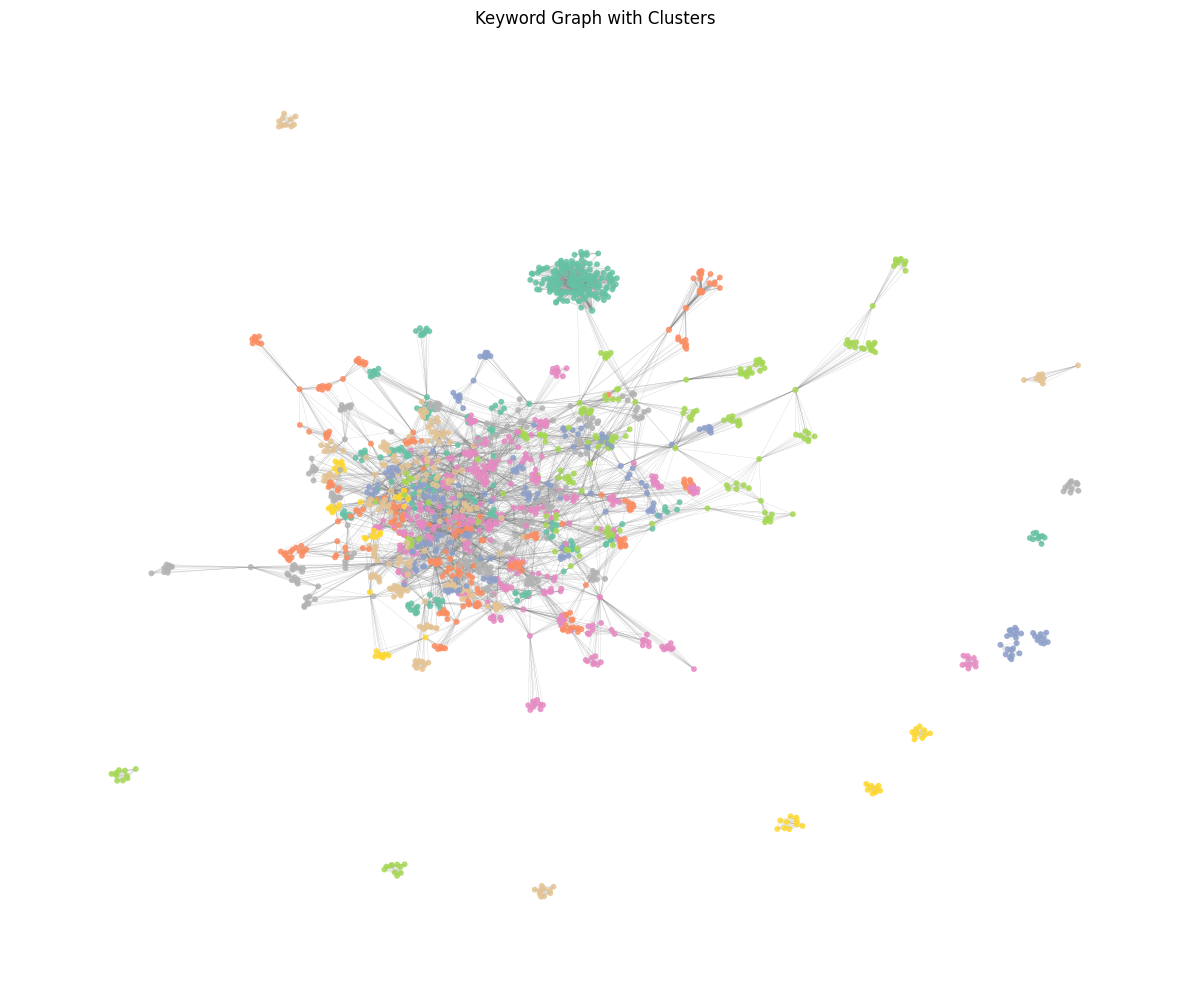

In [105]:
visualize_keyword_graph(KG, partition, title="Keyword Graph with Clusters")

In [83]:
cent_df = compute_centralities(KG)

In [84]:
cent_df = sort_centralities(cent_df,'degree')
print(cent_df[['node','degree']].head(10))

                       node    degree
448                      ai  0.098681
36               conference  0.094987
34   conference uncertainty  0.090237
35   uncertainty artificial  0.090237
87                    model  0.055937
382                  system  0.051715
506               algorithm  0.045910
85               technology  0.040633
409                 machine  0.040106
304                    game  0.037995


In [85]:
cent_df = sort_centralities(cent_df,'betweenness')
print(cent_df[['node','betweenness']].head(10))

                      node  betweenness
448                     ai     0.172367
36              conference     0.153383
614                society     0.113682
85              technology     0.078782
87                   model     0.070461
304                   game     0.068780
382                 system     0.068430
306  intelligence research     0.061219
506              algorithm     0.059963
855                network     0.047938


In [86]:
cent_df = sort_centralities(cent_df,'eigenvector')
print(cent_df[['node','eigenvector']].head(10))

                       node  eigenvector
36               conference     0.507671
34   conference uncertainty     0.507038
35   uncertainty artificial     0.507038
109                  twenty     0.227644
108       proceeding twenty     0.227644
237                   third     0.049657
236        third conference     0.049657
113                   sixth     0.049657
119                   fifth     0.049657
118        fifth conference     0.049657


In [87]:
cent_df = sort_centralities(cent_df,'closeness')
print(cent_df[['node','closeness']].head(10))

           node  closeness
448          ai   0.391667
382      system   0.356070
402   ai system   0.355966
87        model   0.353223
85   technology   0.353006
410    learning   0.346424
866   education   0.343734
89        field   0.343414
506   algorithm   0.338409
773          ml   0.337835


In [88]:
cent_df.to_csv("keyword_centralities.csv", index=False)

In [89]:
PG = build_publication_graph(kp)
nx.write_gexf(PG, "publication_graph.gexf")
print(f"nodes={PG.number_of_nodes()}, edges={PG.number_of_edges()}")

sample_paper = list(kp.keys())[0]
print(sample_paper)
print(find_similar_papers_by_neighbors(PG, sample_paper, k=10))
print(find_similar_papers_by_shortest_path(PG, sample_paper, k=10))

nodes=250, edges=1554
http://arxiv.org/abs/2304.02924v1
[('http://arxiv.org/abs/1812.02953v1', 1), ('http://arxiv.org/abs/1908.11779v1', 1), ('http://arxiv.org/abs/2010.14376v1', 1)]
[('http://arxiv.org/abs/1812.02953v1', 1.0), ('http://arxiv.org/abs/1908.11779v1', 1.0), ('http://arxiv.org/abs/2010.14376v1', 1.0), ('http://arxiv.org/abs/1512.00977v1', 1.5), ('http://arxiv.org/abs/1701.07769v1', 1.5), ('http://arxiv.org/abs/2111.02001v1', 1.5), ('http://arxiv.org/abs/2110.00828v1', 1.5), ('http://arxiv.org/abs/2412.08273v1', 2.0), ('http://arxiv.org/abs/1304.1527v1', 2.0), ('http://arxiv.org/abs/1901.11184v1', 2.0)]


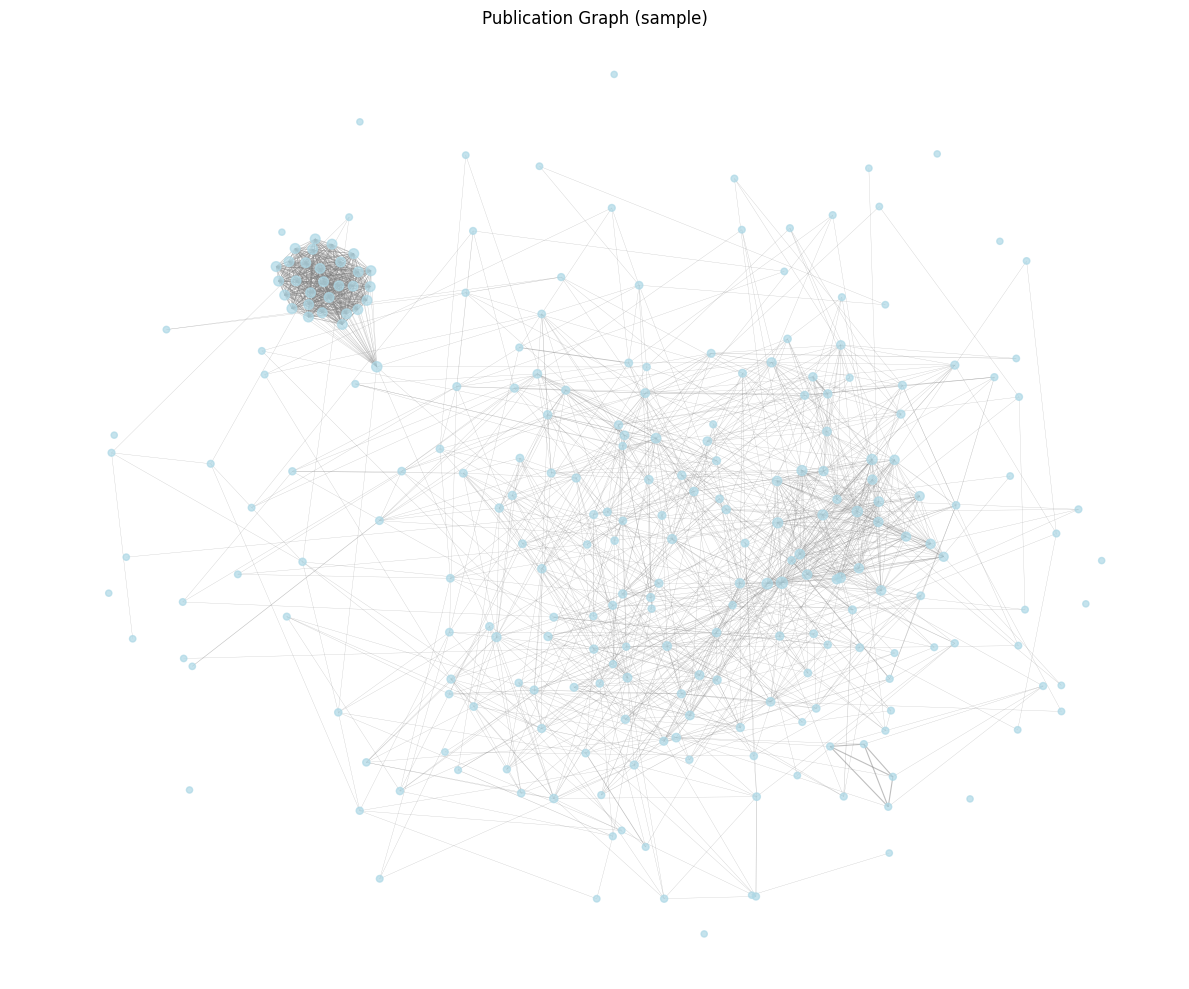

In [106]:
visualize_publication_graph(PG, title="Publication Graph (sample)")